# Point cloud classification using RandLA-Net

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#RandLA-Net-architecture" data-toc-modified-id="RandLA-Net-architecture-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>RandLA-Net architecture</a></span><ul class="toc-item"><li><span><a href="#Local-Feature-Aggregation" data-toc-modified-id="Local-Feature-Aggregation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Local Feature Aggregation</a></span></li></ul></li><li><span><a href="#Implementation-in-arcgis.learn" data-toc-modified-id="Implementation-in-arcgis.learn-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Implementation in <code>arcgis.learn</code></a></span><ul class="toc-item"><li><span><a href="#For-advanced-users" data-toc-modified-id="For-advanced-users-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>For advanced users</a></span></li></ul></li><li><span><a href="#Setting-up-the-environment" data-toc-modified-id="Setting-up-the-environment-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Setting up the environment</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#For-ArcGIS-Pro-users:" data-toc-modified-id="For-ArcGIS-Pro-users:-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>For ArcGIS Pro users:</a></span></li><li><span><a href="#For-Anaconda-users-(Windows-and-Linux-platforms):" data-toc-modified-id="For-Anaconda-users-(Windows-and-Linux-platforms):-4.0.2"><span class="toc-item-num">4.0.2&nbsp;&nbsp;</span>For Anaconda users (Windows and Linux platforms):</a></span></li></ul></li></ul></li><li><span><a href="#Best-practices-for-RandLA-Net-workflow" data-toc-modified-id="Best-practices-for-RandLA-Net-workflow-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Best practices for RandLA-Net workflow</a></span></li><li><span><a href="#References" data-toc-modified-id="References-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>References</a></span></li></ul></div>

## Introduction

The `arcgis.learn` module has an efficient point cloud classification model called RandLA-Net <a href="#References">[1]</a>, which can be used to classify a large number of points in a point cloud dataset. In general, point cloud datasets are gathered using LiDAR sensors, which apply a laser beam to sample the earth's surface and generate high-precision x, y, and z points. These points, are known as 'point clouds' and are commonly generated through the use of terrestrial and airborne LiDAR.

Point clouds are collections of 3D points that carry the location, measured in x, y, and z coordinates. These points also have some additional information like 'GPS timestamps', 'intensity', and 'number of returns'. The intensity represents the returning strength from the laser pulse that scanned the area, and the number of returns shows how many times a given pulse returned. LiDAR data can also be fused with RGB (red, green, and blue) bands, derived from imagery taken simultaneously with the LiDAR survey. 

Point cloud classification are based on the type of object that reflected the laser pulse. For example, a point that reflects off the ground is classified into the ground category. LiDAR points can be classified into different categories like buildings, trees, highways, water, etc. These different classes have numeric codes assigned to them.

<p align="center">
<center>
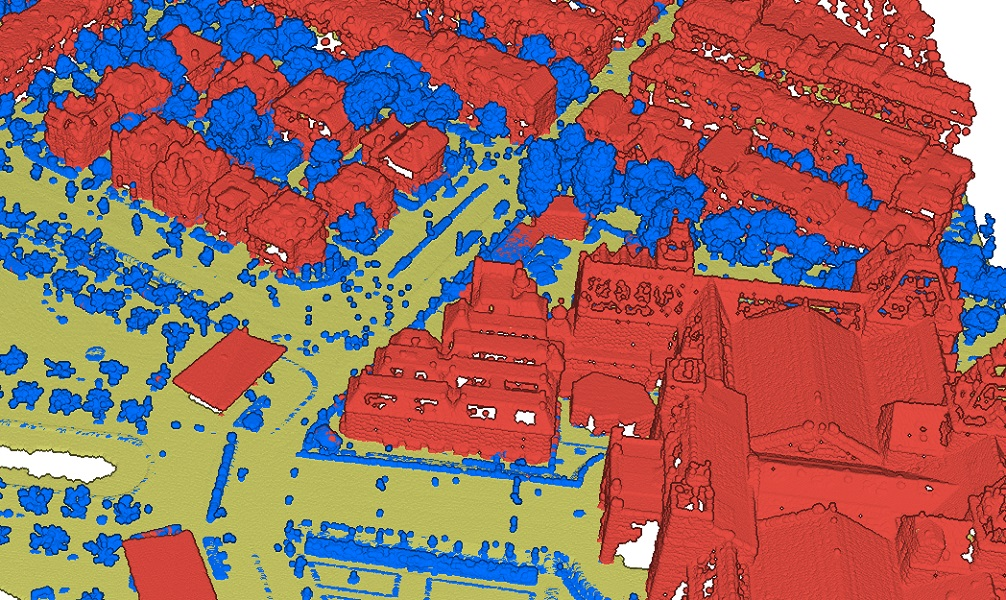
</center>
</p>
<br>
<center>Figure 1. Visualization of point cloud dataset, with classes represented by different colors.</center>

Point cloud classification is a task where each point in the point cloud is assigned a label, representing a real-world entity (see Figure 1.). And similar to how it's done in traditional methods, for deep learning, the point cloud classification process involves training – where the neural network learns from an already classified (labeled) point cloud dataset, where each point has a unique class code. These class codes are used to represent the features that we want the neural network to recognize. 

In deep learning workflows for point cloud classification, one should not use a ‘thinned-out’ representation of a point cloud dataset that preserves only class codes of interest but drops a majority of the undesired return points, as we would like the neural network to learn and be able to differentiate points of interest and those that are not. Likewise, additional attributes that are present in training datasets, for example, Intensity, RGB, number of returns, etc. will improve the model’s accuracy but could inversely affect it if those parameters are not correct in the datasets that are used for inferencing.

When it comes to classifying point clouds, deep learning and neural networks are a great choice since they offer a scalable and efficient architecture. They have enormous potential to make manual or semi-assisted classification modes of point clouds a thing of the past. With that in mind, we can take a closer look at the RandLA-Net model included in `arcgis.learn` and how it can be used for point cloud classification.

RandLA-Net is a unique architecture that utilizes random sampling and a local feature aggregator to improve efficient learning and semantic segmentation on a large-scale for point clouds. Compared to existing approaches, RandLA-Net is up to 200 times faster and surpasses state-of-the-art benchmarks like Semantic3D and SemanticKITTI. Its effective local feature aggregation approach preserves complex local structures and delivers significant memory and computational gains over other methods <a href="#References">[1]</a>.

## RandLA-Net architecture

<p align="center">
<center>
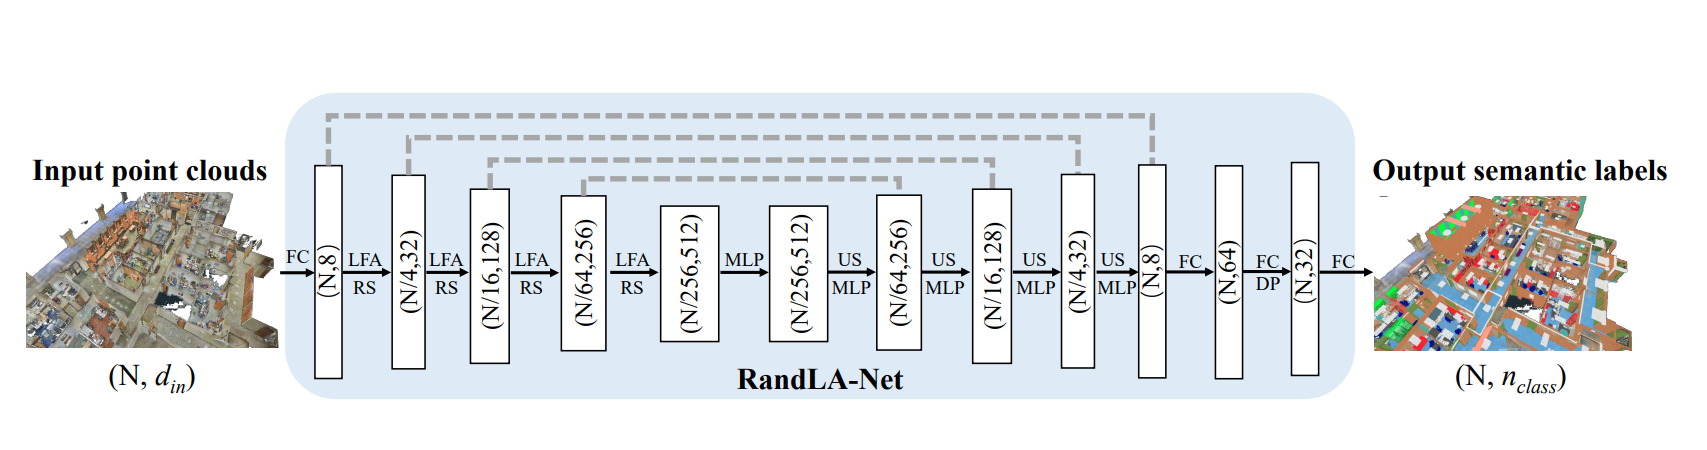
</center>
</p>
<br>
<center>Figure 2. The detailed architecture of RandLA-Net. (N, D) represents the number of points and feature dimension respectively. FC: Fully Connected layer, LFA: Local Feature Aggregation, RS: Random Sampling, MLP: shared Multi-Layer Perceptron, US: Up-sampling, DP: Dropout <a href="#References">[1]</a>.</center>

RandLA-Net is an architecture that allows for the learning of point features within a point cloud by using an encoder-decoder sequence with skip connections. The network applies shared MLP layers along with four encoding and decoding layers, as well as three fully-connected layers and a dropout layer to predict the semantic label of each point (see Figure 2.).


- The input to the architecture is a large-scale point cloud consisting of N points with feature dimensions of d<sub>in</sub>, where the batch dimension is dropped for simplicity.


- To reduce the size of the point clouds and increase per-point feature dimensions, four encoding layers are progressively applied. Each of these layers includes a local feature aggregation module and random sampling operation. The number of point features is then reduced to 25% after each layer, but the per-point feature dimension is gradually increased each time to preserve more information (see Figure 2.).


- Following the encoding layers, four decoding layers are employed, with the KNN algorithm being used to find the nearest neighboring point for each query point in each decoder layer. The point feature set is then up-sampled through a nearest-neighbor interpolation, and both the up-sampled feature maps and intermediate feature maps produced by encoding layers are concatenated through skip connections. Finally, a shared MLP is applied to these concatenated feature maps.


- The final semantic label of each point is predicted by three fully-connected layers, (N, 64) → (N, 32) → (N, n<sub>class</sub>), and a dropout layer. The dropout ratio is 0.5.


- The output of RandLA-Net is the predicted semantics of all points, with a size of N × n<sub>class</sub>, where n<sub>class</sub> is the number of classes <a href="#References">[1]</a>.


### Local Feature Aggregation

<p align="center">
<center>
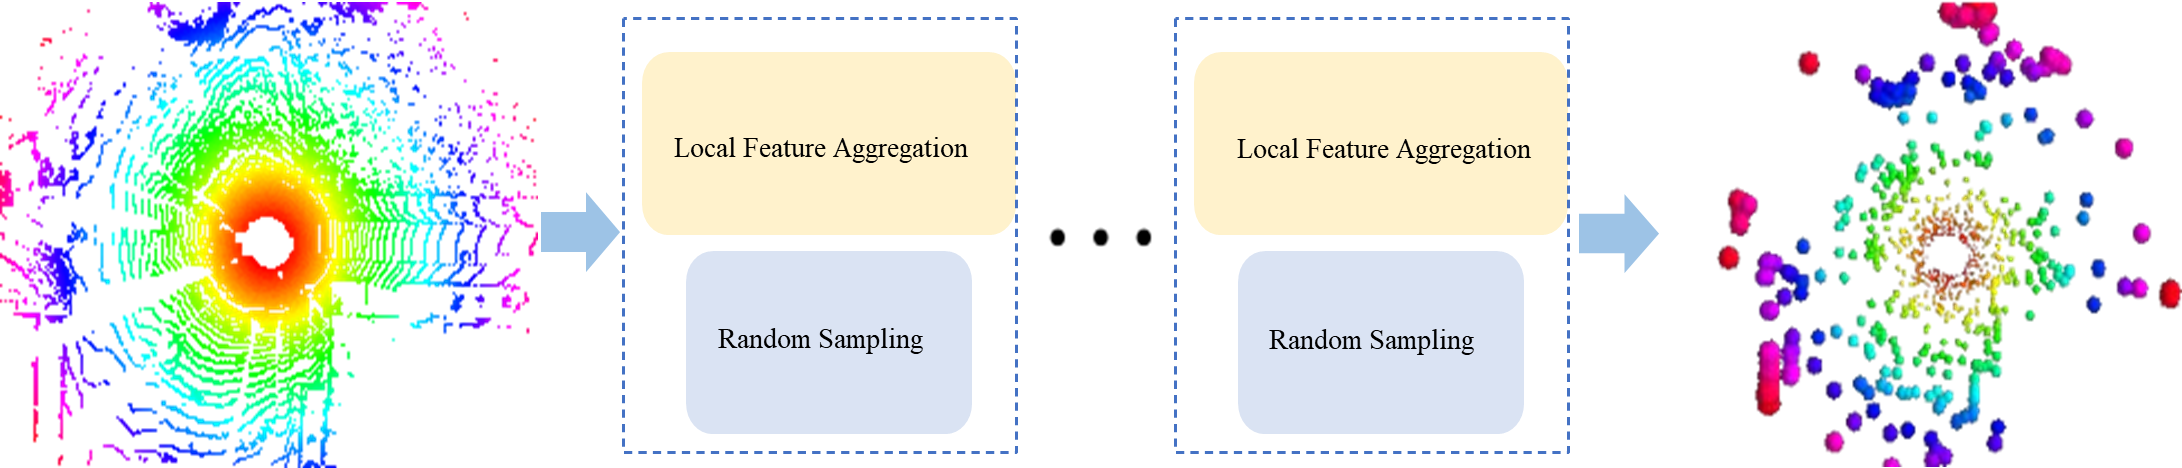
</center>
</p>
<br>
<center>Figure 3. RandLA-Net utilizes downsampling of point clouds at each layer, while still preserving important features required for precise classification <a href="#References">[1]</a>.</center>

A core novelty of the RandLA-Net framework is the local feature aggregator. Local feature aggregation is a technique that uses neural networks to learn complex geometric structures in 3D points by increasing the receptive field size in each neural layer. The process includes a local spatial encoding unit and attentive pooling to identify useful local features. These components are stacked as a dilated residual block, making the process memory and computation efficient. 

The local feature aggregation module is applied to each 3D point in parallel, which includes three neural units namely,

- local spatial encoding (LocSE),
- attentive pooling,
- and dilated residual block.

These units work together to learn complex local structures by preserving local geometric features while progressively increasing the receptive field size in each neural layer (see Figure 3.). The LocSE unit is introduced first to capture the local spatial encoding of the point. Then, the attentive pooling unit is leveraged to select the most useful local features that contribute the most to the classification task. Finally, the multiple LocSE and attentive pooling units are stacked together as a dilated residual block to further enhance the effective receptive field for each point in a computationally efficient way.

<p align="center">
<center>
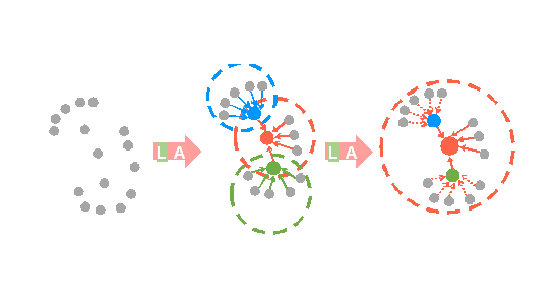
</center>
</p>
<br>
<center>Figure 4. Illustration of the dilated residual block which significantly increases the receptive field (dotted circle) of each point, colored points represent the aggregated features. L: Local spatial encoding, A: Attentive pooling <a href="#References">[1]</a>.</center>

In local spatial encoding, the neighboring point's x, y, and z coordinates are explicitly embedded along with per-point features to allow the LocSE unit to observe and encode local geometric patterns in the point cloud data. The process involves gathering neighboring points using the K-nearest neighbors algorithm, encoding relative point positions based on Euclidean distances, and augmenting point features. The output is a set of neighboring features that encodes local geometric structures.

In an attentive pooling unit, the attention mechanism is used to automatically learn important local features and aggregate neighboring point features while avoiding the loss of crucial information. It also maintains the focus on the overall objective, which is to learn complex local structures in a point cloud by considering the relative importance of neighboring point features.

Lastly in the dilated residual block unit, the receptive field is increased for each point by stacking multiple LocSE and Attentive Pooling units. This dilated residual block operates by cheaply dilating the receptive field and expanding the effective neighborhood through feature propagation (see Figure 4.). Stacking more and more units enhances the receptive field and makes the block more powerful, which may compromise the overall computation efficiency and lead to overfitting. Hence, in RandLA-Net, two sets of LocSE and Attentive Pooling are stacked as a standard residual block to achieve a balance between efficiency and effectiveness <a href="#References">[1]</a>.

## Implementation in `arcgis.learn`

When training a RandLA-Net model using `arcgis.learn`, the raw point cloud dataset in LAS files is first converted into blocks of points, containing a specific number of points along with their class codes.

<p align="center">
<center>
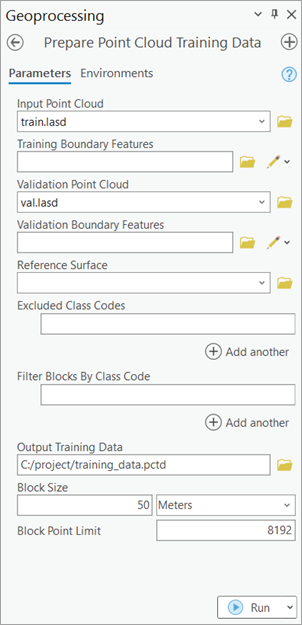
</center>
</p>
<br>
<center>Figure 5. <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/prepare-point-cloud-training-data.htm" target="_blank">Prepare Point Cloud Training Data</a> tool in ArcGIS Pro.</center>

For this step of exporting the data into an intermediate format, use <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/prepare-point-cloud-training-data.htm" target="_blank">Prepare Point Cloud Training Data</a> tool, in the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/an-overview-of-the-3d-analyst-toolbox.htm" target="_blank">3D Analyst extension</a>, available from ArcGIS Pro 2.8 onwards (see Figure 5.).

These exported blocks are used to create a `data bunch` object that is passed into the `RandLANet` model for training.

```python
output_path=r'C:/project/training_data.pctd'
data = prepare_data(output_path, dataset_type='PointCloud', batch_size=2)
rl = RandLANet(data)
rl.fit(20)
```
After training the RandLA-Net model, `compute_precision_recall()` method can be used to compute, per-class metrics (precision, recall, and f1-score) with respect to validation data. And `save()` method can be used to save the model.

<p align="center">
<center>
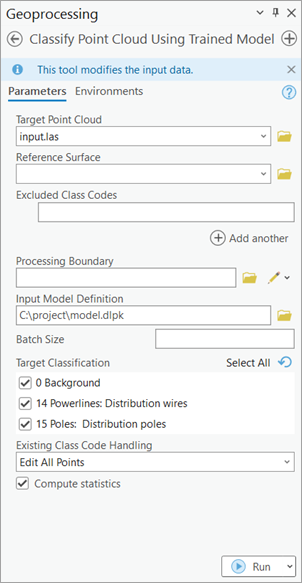
</center>
</p>
<center>Figure 6. <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/classify-point-cloud-using-trained-model.htm" target="_blank">Classify Points Using Trained Model</a> tool. </center>

For inferencing, use <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/classify-point-cloud-using-trained-model.htm" target="_blank">Classify Points Using Trained Model</a> tool, in the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/an-overview-of-the-3d-analyst-toolbox.htm" target="_blank">3D Analyst extension</a>, available from ArcGIS Pro 2.8 onwards (see Figure 6.).

Main features available during the inferencing step:
       
- _Target classification:_ selective classification for flexibility and control in trained model's predictions.


- _Preserving specific classes in input data from modification:_ this can be used for updating old datasets and for noise control in model's prediction.

Detailed tool references and resources for point cloud classification using deep learning in ArcGIS Pro can be found <a href="https://pro.arcgis.com/en/pro-app/latest/help/data/las-dataset/introduction-to-deep-learning-and-point-clouds.htm" target="_blank">here</a>.

### For advanced users 

We can also specify, additional parameters that directly affect the properties of the architecture itself, this can be done while initializing the `RandLANet` model while using the API, by using `encoder_params` keyword argument.

It is an optional dictionary which can be used to specify:

- `out_channels` that can set the number of channels produced by each layer.


- `sub_sampling_ratio` which sets the sampling ratio of random sampling at each layer.


- `k_n` controls the number of K-nearest neighbors for a point.


A typical usage with respect to API looks like:

```python
rl = RandLANet(data=data, 
               encoder_params={'out_channels':[16, 64, 128, 256],
                               'sub_sampling_ratio':[4, 4, 4, 4],
                               'k_n':16,
                              }
               )
```

## Setting up the environment

<i>Make sure to update your 'GPU driver' to a recent version and use 'Administrator Rights' for all the steps, written in this guide.</i>

_**Below, are the instructions to set up the required 'conda environment':**_

#### For ArcGIS Pro users:

<a href="https://github.com/esri/deep-learning-frameworks" target="_blank">Deep learning frameworks</a>
can be used to install all the required dependencies in  ArcGIS Pro's default python environment using an MSI installer. 

Alternatively,  
for a cloned environment of ArcGIS Pro's default environment, `deep-learning-essentials` metapackage can be used to install the required dependencies which can be done using the following command, in the _`Python Command Prompt`_ <i>(included with ArcGIS Pro)</i>:

`conda install deep-learning-essentials`

#### For Anaconda users (Windows and Linux platforms):

`arcgis_learn` metapackage can be used for both `windows` and `linux` installations of `Anaconda` in a new environment.

The following command will update `Anaconda` to the latest version. 

`conda update conda`

After that, metapackage can be installed using the command below:

`conda install -c esri arcgis_learn=3.9`

## Best practices for RandLA-Net workflow

The following tips and best practices can be used while using RandLA-Net:

- The <a href="https://pro.arcgis.com/en/pro-app/latest/help/data/las-dataset/introduction-to-deep-learning-and-point-clouds.htm" target="_blank">3D deep learning tools</a> in the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/an-overview-of-the-3d-analyst-toolbox.htm" target="_blank">3D Analyst extension</a>, takes care of the coordinate system, and related discrepancies, automatically. So, one can train a model using ArcGIS Pro on a dataset with a metric coordinate system, then use that trained model on a dataset with any other coordinate system, and vice-versa without any need for re-projection.

- High-quality labeled data will result in a better-trained model. For generalization and robustness of the trained model, significant diversity or variety should be present in the training data, in terms of geography, building architectures, terrains, object-related variations, etc.

- If the object of interest is significantly larger or smaller in size than the default value of `Block Size`, then a better value can be used for improving the results further. Like, for a dataset in a metric coordinate system, a _'warehouse'_ won't fit in a '50 meter' x '50 meter' `Block Size`, hence the `Block Size` can be increased in this case. 

- Through a series of experiments, it was found that an additional one or two `extra_features` apart from X, Y, and Z usually works best, in most cases. Over usage of 'extra attributes' for model training might reduce generalization, i.e. _'how generic the trained model will be'_. 

- Deciding which 'extra attributes' to consider, depends upon the properties of the object of interest, the nature of noise, sensor-specific attributes, etc. 

- It is recommended to filter or withheld points that belong to the 'high noise' class from the dataset.

- If the training and validation dataset is very large and each epoch is taking a lot of time to complete, then `iters_per_epoch` can be used to see the epoch/training table quickly by reducing the time taken for the completion of an epoch. This is achieved by a random selection/filtering of fewer batches, governed by the user-provided value of `iters_per_epoch`. So in each epoch, the model is exposed to a lesser number of randomly selected batches, this results in faster completion of an epoch, but it can lead to more numbers of epochs before the model converges. 

- `mask_class` functionality in `show_results()` can be used for analyzing any inter-class noises present in the validation output. This can be used to understand which classes need more diversity in training data or need an increase in its number of labeled points _(As shown below, in Figure 7.)_.


<p align="center"><center><img src="../../static/img/pointcnn_guide_gif_1.gif" /></center></p>

<center>Figure 7. Class-based masking of points, to understand the nature of noise in the prediction.</center>

- The default value of `max_display_point` in `show_batch()` and `show_results()` is set to '20000', keeping the rendering-related browser limitation in mind, which can occur for very dense point clouds. This value can be increased if needed, for detailed visualization, within the browser itself. 

- `Target Classification` and `Class Preservation` in <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/classify-point-cloud-using-trained-model.htm" target="_blank">Classify Points Using Trained Model</a> tool, can be used in conjunction to combine the knowledge of multiple trained models for a single scene. 

- Parameters like, `classes_of_interest` and `min_points` are especially useful when training a model for SfM or mobile/terrestrial point clouds. In specific scenarios when the 'training data' is not small, these features can be very useful in speeding up the 'training time', improving the convergence during training, and addressing the class imbalance up to some extent.

- Fine-tuning a pretrained model is only preferred if the 'object of interest' is either same or similar, else it is not beneficial. Otherwise, fine-tuning a pretrained model can save cost, time, and compute resources while providing better accuracy/quality in results.

- Class codes can be given a meaningful name, using `class_mapping`. The names of the class codes are saved inside the model, which is automatically retrieved by <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/classify-point-cloud-using-trained-model.htm" target="_blank">Classify Points Using Trained Model</a> tool and <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/train-point-cloud-classification-model.htm" target="_blank">Train Point Cloud Classification Model</a> tool, when a trained model is loaded.

- For fine-tuning a model with default architecture settings;  'Class Structure', 'Extra Attributes', and 'Block Point Limit' should match between the pretrained model and the exported 'training data'.

## References


[1] Hu, Q., Yang, B., Xie, L., Rosa, S., Guo, Y., Wang, Z., Trigoni, N., & Markham, A. (2020). Randla-Net: Efficient semantic segmentation of large-scale point clouds. Proceedings of the IEEE Computer Society Conference on Computer Vision and Pattern Recognition, 11105–11114. https://doi.org/10.1109/CVPR42600.2020.01112